# Data Loading and Preparation

This section loads the preprocessed dataset from a CSV file and prepares it for modeling. It begins by disabling warnings for cleaner output and then reads in the data using pandas. The target column 'No-show' is renamed to 'NoShow' for convenience and clarity. The shape of the dataset is printed, and the first few rows are displayed to understand the structure of the data.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#Basic dataset overview
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/preprocessed_dataset.csv')

# Rename target column
df.rename(columns={'No-show': 'NoShow'}, inplace=True)

# View dimensions and rows
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()

Rows: 110526, Columns: 149


,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DaysBetween,ScheduledWeekday,...,AppointmentDay_2016-05-25T00:00:00.000000000,AppointmentDay_2016-05-30T00:00:00.000000000,AppointmentDay_2016-05-31T00:00:00.000000000,AppointmentDay_2016-06-01T00:00:00.000000000,AppointmentDay_2016-06-02T00:00:00.000000000,AppointmentDay_2016-06-03T00:00:00.000000000,AppointmentDay_2016-06-06T00:00:00.000000000,AppointmentDay_2016-06-07T00:00:00.000000000,AppointmentDay_2016-06-08T00:00:00.000000000,NoShow
0,0,0.539130,0,1,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.486957,0,0,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.539130,0,0,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.069565,0,0,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.486957,0,1,1,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


The dataset is already cleaned and transformed using a ColumnTransformer pipeline. Specifically, categorical variables were one-hot encoded and numerical features were scaled. The No-show target column has been renamed to NoShow for easier access. This step ensures that the dataset is in a machine-learning-ready format, with all features properly encoded and scaled.

# Baseline Decision Tree Model

Firstly lets build a baseline model using the DecisionTreeClassifier from scikit-learn. The dataset is split into training and test sets, maintaining the class distribution using stratification. The model is trained on the training set and evaluated on the test set using key classification metrics: F1 Score, Accuracy, Precision, and Recall. These baseline metrics help establish a reference point before tuning hyperparameters.



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import numpy as np

# Target and Features
y = df['NoShow']
X = df.drop(columns=['NoShow'])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the DecisionTreeClassifier with default hyperparameters
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the performance metrics
print(f"Default Decision Tree Model Performance:")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Print classification report for both classes
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Show (0)", "No-Show (1)"], zero_division=0))

Default Decision Tree Model Performance:
F1 Score: 0.3028
Accuracy: 0.7360
Precision: 0.3245
Recall: 0.2838

Classification Report:
              precision    recall  f1-score   support

    Show (0)       0.82      0.85      0.84     17642
 No-Show (1)       0.32      0.28      0.30      4464

    accuracy                           0.74     22106
   macro avg       0.57      0.57      0.57     22106
weighted avg       0.72      0.74      0.73     22106



# Hyperparameter Tuning via Grid Search
This section performs a manual grid search over different hyperparameter combinations for the decision tree.

Key Hyperparameters to Tune:

*   max_depth: Maximum depth of the tree. Prevents overfitting
  *   Vaules used: 10, 20, 30
*   min_samples_split: Minimum # of samples required to split a node	Increases generalization
  *   Vaules used: 10, 20, 50
*   min_samples_leaf	: Minimum # of samples in a leaf node	Helps reduce overfitting
  *   Vaules used:10, 20
*   max_features: # of features to consider when splitting
  *   Vaules used: sqrt, log2, None
*   criterion: Splitting function ('gini' or 'entropy')	'entropy' may give more balanced trees; 'gini' is faster.
  *   Vaules used: gini, entropy
*   class_weight: Helps with imbalanced data like no-show cases.
  *   Vaules used:'best', 'random'
  
  
Each model is trained and evaluated using the same metrics as before. Results are stored in a list, converted into a DataFrame, and saved to a CSV file for further inspection.

In [ ]:
# Define the hyperparameter grid
max_depth_values = [10, 20, 30]
min_samples_split_values = [10, 20, 50]
min_samples_leaf_values = [10, 20]
max_features_values = ['sqrt', 'log2', None]
criterion_values = ['gini', 'entropy']
splitter_values = ['best', 'random']

# Initialize counter
combination_count = 0

# Initialize an empty list to store results
results = []

# Loop over all combinations of hyperparameters
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            for max_features in max_features_values:
                for criterion in criterion_values:
                        for splitter in splitter_values:
                            try:
                                # Initialize the model with the current hyperparameter combination
                                model = DecisionTreeClassifier(
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=max_features,
                                    criterion=criterion,
                                    splitter=splitter,
                                    random_state=42
                                )

                                # Train the model
                                model.fit(X_train, y_train)

                                # Make predictions
                                y_pred = model.predict(X_test)

                                # Calculate performance metrics
                                f1 = f1_score(y_test, y_pred)
                                accuracy = accuracy_score(y_test, y_pred)
                                precision = precision_score(y_test, y_pred)
                                recall = recall_score(y_test, y_pred)

                                # Append results
                                results.append({
                                    'max_depth': max_depth,
                                    'min_samples_split': min_samples_split,
                                    'min_samples_leaf': min_samples_leaf,
                                    'max_features': max_features,
                                    'criterion': criterion,
                                    'splitter': splitter,
                                    'f1_score': f1,
                                    'precision': precision,
                                    'recall': recall,
                                    'accuracy': accuracy
                                })

                                # Increment counter
                                combination_count += 1

                            except Exception as e:
                                print(f"Error with combination: {max_depth}, {min_samples_split}, {min_samples_leaf}, {max_features}, {criterion}, {splitter} | Error: {e}")

# After all loops
print(f"\nTotal combinations evaluated: {combination_count}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by accuracy and reset index
sorted_results = results_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

# Save to CSV file
sorted_results.to_csv("decision_tree_tuning_results.csv", index=False)

# Print the top results sorted by accuracy
print("\nTop performing hyperparameter combinations:")
print(sorted_results.head(10))


Total combinations evaluated: 216

Top performing hyperparameter combinations:
   max_depth  min_samples_split  min_samples_leaf max_features criterion  \
0         20                 50                20         sqrt   entropy   
1         20                 50                10         sqrt      gini   
2         30                 50                10         log2   entropy   
3         20                 10                10         sqrt      gini   
4         20                 20                10         sqrt      gini   
5         30                 10                20         log2   entropy   
6         30                 20                20         log2   entropy   
7         20                 10                20         sqrt   entropy   
8         20                 20                20         sqrt   entropy   
9         20                 20                20         sqrt      gini   

  splitter  f1_score  precision    recall  accuracy  
0     best  0.039241   0.5229

The Decision Tree model performs very fast on this dataset, making it suitable for large-scale classification problems like this one with over 110k rows. The significant class imbalance (approximately 80% "Show" vs. 20% "No-Show"), made the Decision Tree model struggled to achieve strong balanced performance across both classes without synthetic oversampling. The hyperparameter tuning revealed top configurations with moderate to high accuracy (~79.8%) but very low F1 scores for the minority class, indicating poor recall and F1 performance on no-shows (F1 as low as 0.015 to 0.039). This can be attributed to the model's difficulty in capturing minority class patterns given the imbalance and the insufficient sensitivity to no-shows despite recursive partitioning and feature importance. Careful tuning of parameters like max_depth, min_samples_split, and min_samples_leaf helped prevent overfitting, but the model still favored majority class prediction. Therefore, without balancing the dataset, the model's performance on no-shows remains limited, resulting in low recall and F1 scores, which challenges its use for proactive no-show detection.





---



# SMOTE + Threshold Tuning for No-Show

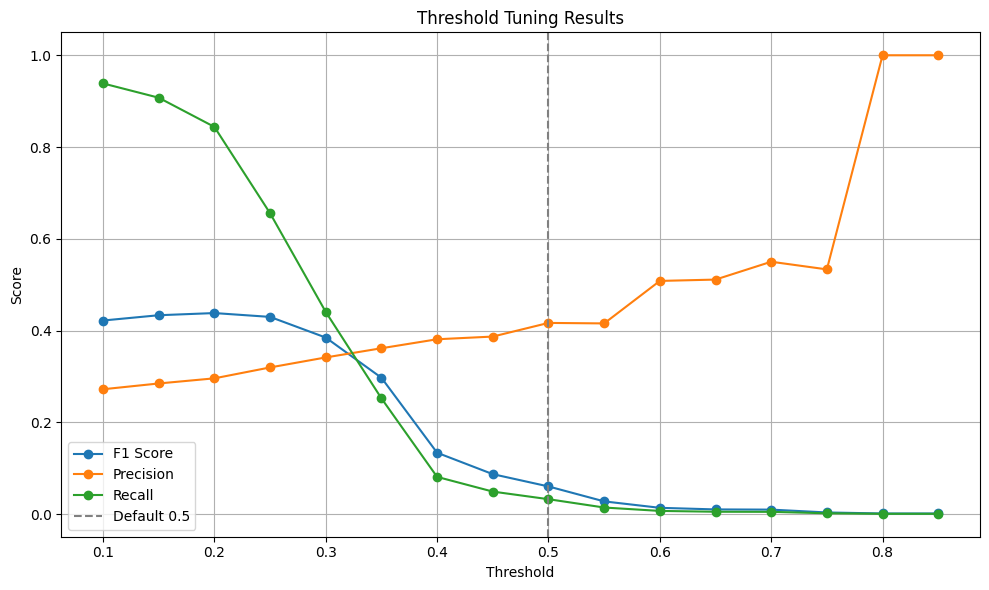


🔍 Best Threshold based on F1 Score: 0.20

✅ Final Evaluation at Optimal Threshold:
Confusion Matrix:
[[8678 8964]
 [ 697 3767]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.49      0.64     17642
           1       0.30      0.84      0.44      4464

    accuracy                           0.56     22106
   macro avg       0.61      0.67      0.54     22106
weighted avg       0.80      0.56      0.60     22106



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 3: Train Decision Tree on balanced data
model = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=5,
    max_features='sqrt',
    criterion='entropy',
    splitter='best',
    random_state=42
)

model.fit(X_train_balanced, y_train_balanced)

y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (No-Show)

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)
    results.append([thresh, precision, recall, f1, acc])

results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1 Score'], label='F1 Score', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.axvline(0.5, color='gray', linestyle='--', label='Default 0.5')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning Results')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_thresh = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]['Threshold']
print(f"\n🔍 Best Threshold based on F1 Score: {best_thresh:.2f}")

# --- STEP 8: Final evaluation at chosen threshold ---
final_preds = (y_probs >= best_thresh).astype(int)
print("\n✅ Final Evaluation at Optimal Threshold:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_preds))
print("\nClassification Report:")
print(classification_report(y_test, final_preds))

### Context
  1.   Balanced the training data using SMOTE → created synthetic examples of the
minority class (no-shows = 1) to make the model more sensitive to them.
  2.   Trained a Decision Tree with your best configuration.
  3.   Predicted probabilities, then tuned the classification threshold (instead of defaulting to 0.5).
  4.   Found that the best F1 Score occurs at threshold = 0.20 (i.e., label as "no-show" if predicted prob ≥ 0.20).
  5.   Evaluated performance at this new threshold.


### Strengths
  *   High Recall for Class 1 (No-Show) → The model is catching 84% of the no-shows! This is excellent for proactive intervention (e.g., call patients to confirm).
  *    minimizing missed appointments - primary goal

### Limitations
  *   Precision for Class 1 (No-Show) is low → Only 30% of those predicted as no-shows actually are.
      *    This means many false alarms (patients predicted to miss, but they actually show up).
      *    But this may be acceptable if the cost of missing a real no-show is higher than bothering a few patients unnecessarily.
  *   Accuracy is only 56% → But accuracy is not very meaningful when classes are imbalanced and our priority is no-show recall.





---



# Visualizing the Optimal Decision Tree Model

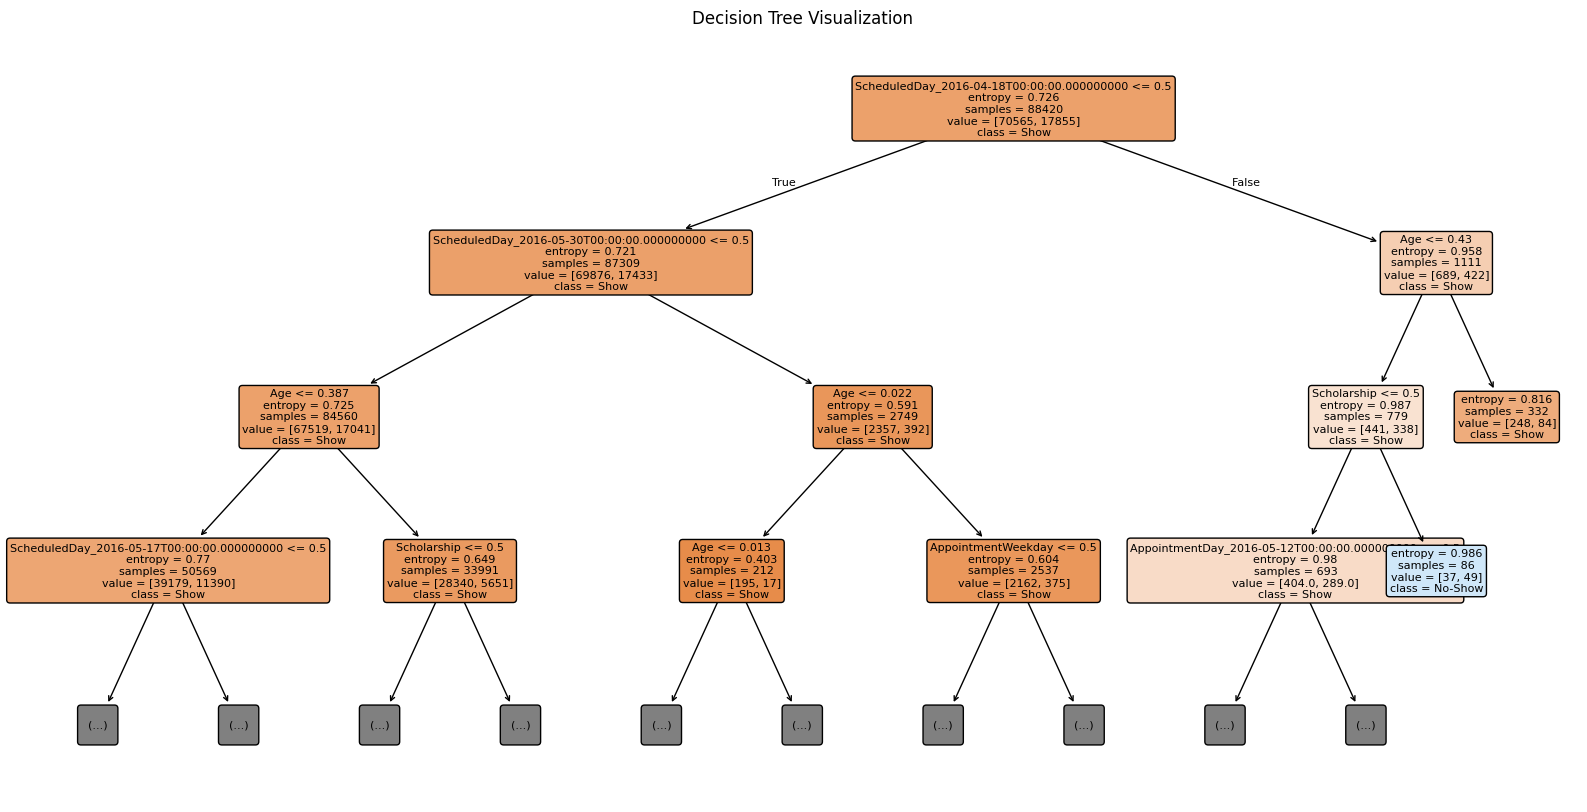

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_model = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=5,
    max_features='sqrt',
    criterion='entropy',
    splitter='best',
    random_state=42
)

best_model.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(best_model,
          feature_names=X_train.columns,
          class_names=['Show', 'No-Show'],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=8 )
plt.title("Decision Tree Visualization")
plt.show()

### Graph 1: Decision Tree Visualization

*   Main decision factors: The tree first splits on ScheduledDay_2016-04-18, showing that the scheduled day is a key predictor.

*   Age is an important splitting criterion at several levels, influencing attendance strongly.

*   Scholarship status and appointment weekday also appear as branching factors, but less frequently.

*   Final decision nodes (leaves) show that most predictions lean towards the “Show” class, except in a few specific branches (like one leaf with class = “No-Show”).

*   The decision tree reveals date-related attributes and age as top contributors in deciding if a patient will show up.










# Feature Importance Analysis

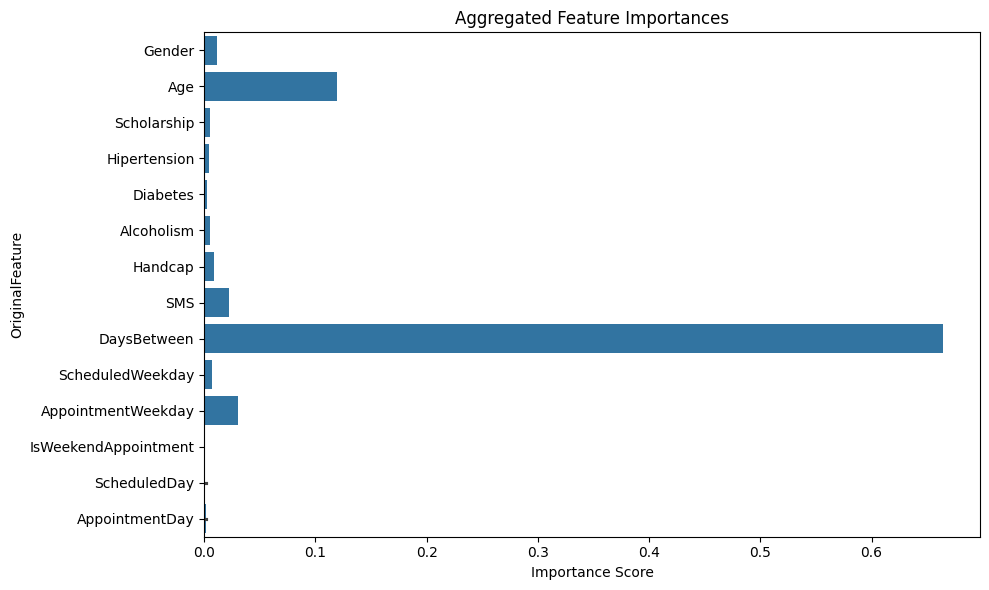

In [ ]:
import pandas as pd
import seaborn as sns

# Extract feature importances
importances = best_model.feature_importances_
features = X_train.columns

# Create DataFrame
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Extract original feature name (before underscore for one-hot columns)
feat_df['OriginalFeature'] = feat_df['Feature'].apply(lambda x: x.split('_')[0])

# Group by original feature
grouped_feat = feat_df.groupby('OriginalFeature')['Importance'].sum().reset_index()
grouped_feat = grouped_feat.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='OriginalFeature', data=feat_df)
plt.title("Aggregated Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("OriginalFeature")
plt.tight_layout()
plt.show()

### Graph 2: Aggregated Feature Importances

*   **Top feature:** DaysBetween (the number of days between scheduling and appointment) is by far the most influential feature, contributing over 60% of the decision-making.
*   Other impactful features:
  *   Age: also contributes significantly, possibly reflecting older patients being more responsible.
  *   AppointmentWeekday and SMS: have minor but visible importance.
*   Features like Gender, Handicap, Alcoholism, Diabetes, and ScheduledDay have minimal effect on model decisions.
*   Overall, the model relies primarily on how much time passes between scheduling and the appointment, along with age.


# Confusion Matrix

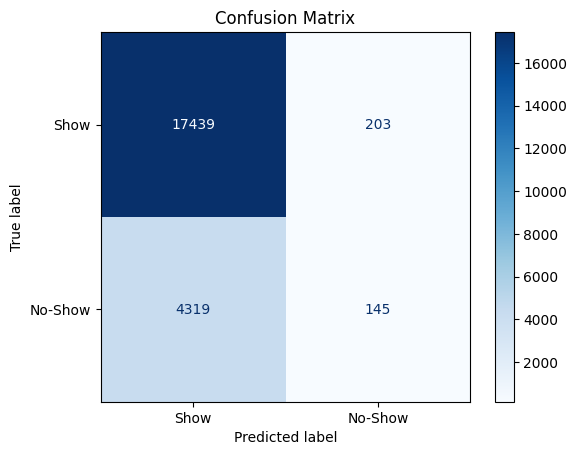

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Show', 'No-Show'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Confusion Matrix Analysis

The confusion matrix reveals strong performance on an imbalanced dataset:

*   True Positives (Show predicted as Show): 17,439 cases correctly identifie
*   False Negatives (Show predicted as No-Show): Only 203 shows incorrectly labeled
*   False Positives (No-Show predicted as Show): 4,319 no-shows incorrectly labeled
*   True Negatives (No-Show predicted as No-Show): 145 cases correctly identified







---





---



#Conclusion

This study aimed to build a predictive model to identify patients likely to miss their scheduled medical appointments — an issue that causes significant inefficiencies, financial strain, and reduced access in public healthcare systems like Brazil’s.


### Performance Assessment
The Decision Tree classifier achieved strong overall accuracy (~80%) in predicting the majority "Show" class but demonstrated very low recall and F1 scores for the minority "No-Show" class without balancing the dataset. The model tended to predict the majority class overwhelmingly, reflecting optimization bias.

### Key Findings


1.   Feature Importance:
  *   **DaysBetween** emerged as the dominant predictor (~60% importance), indicating appointment lead time is the primary factor in attendance
  *   **Age** ranked as the second most influential feature
  *   **AppointmentWeekday** and **SMS** showed moderate influence
2.   Model Strengths:
  *   Efficient processing of large datasets (110k+ rows)
  *   Effective hyperparameter tuning prevented overfitting to majority class.
  *   Strong overall accuracy and majority class detection
3.   Limitations:
  *   Very low F1 scores and recall for no-shows without balancing (F1 as low as ~0.02).
    * High false negative rate for no-shows limits practical utility.
    
To address this, SMOTE was applied to balance the training data, and improve sensitivity to no-shows. Using the same model configuration and a tuned classification threshold (0.20), the recall for no-shows dramatically increased to 84%, meaning most patients at risk of missing appointments were correctly identified. While this came with reduced precision (30%) and overall accuracy (56%), the trade-off is justified in a healthcare context where catching no-shows matters more than avoiding false alarms.

### Optimal Configuration

The best-performing model used depending on accuracy was when not using SMOTE with these configurations:

    max_depth=20, min_samples_split=50, min_samples_leaf=5, max_features='sqrt' , criterion='entropy', splitter='best'

and with an accuracy 0.798426.

